In [98]:
import torch
import os
import numpy as np
from models import SAVi
from data import gestalt
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from metrics import adjusted_rand_index 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dl = DataLoader(gestalt.Gestalt(root_dir="/om/user/yyf/CommonFate/scenes", sub_level=["superquadric_2"]))

In [174]:
batch = next(iter(dl))

images = batch['images']
flows = batch['flows']
masks = batch['masks']

In [175]:
unique_masks = []
for mask in masks.unique():
    m = torch.where(masks == mask, masks, torch.zeros_like(masks))
    idxs = m > 0
    print(idxs.shape)
    m[idxs] = 255
    unique_masks.append(m)

unique_masks = torch.cat(unique_masks, 0).unsqueeze(0)[..., :]
gt = unique_masks.reshape(1, 3, -1)
gt = gt.permute(0, 2, 1)

torch.Size([1, 10, 3, 128, 128])
torch.Size([1, 10, 3, 128, 128])
torch.Size([1, 10, 3, 128, 128])


In [176]:
# es Limited. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""Implementation of the adjusted Rand index."""

import tensorflow.compat.v1 as tf


def tf_adjusted_rand_index(true_mask, pred_mask, name='ari_score'):
  r"""Computes the adjusted Rand index (ARI), a clustering similarity score.
  This implementation ignores points with no cluster label in `true_mask` (i.e.
  those points for which `true_mask` is a zero vector). In the context of
  segmentation, that means this function can ignore points in an image
  corresponding to the background (i.e. not to an object).
  Args:
    true_mask: `Tensor` of shape [batch_size, n_points, n_true_groups].
      The true cluster assignment encoded as one-hot.
    pred_mask: `Tensor` of shape [batch_size, n_points, n_pred_groups].
      The predicted cluster assignment encoded as categorical probabilities.
      This function works on the argmax over axis 2.
    name: str. Name of this operation (defaults to "ari_score").
  Returns:
    ARI scores as a tf.float32 `Tensor` of shape [batch_size].
  Raises:
    ValueError: if n_points <= n_true_groups and n_points <= n_pred_groups.
      We've chosen not to handle the special cases that can occur when you have
      one cluster per datapoint (which would be unusual).
  References:
    Lawrence Hubert, Phipps Arabie. 1985. "Comparing partitions"
      https://link.springer.com/article/10.1007/BF01908075
    Wikipedia
      https://en.wikipedia.org/wiki/Rand_index
    Scikit Learn
      http://scikit-learn.org/stable/modules/generated/\
      sklearn.metrics.adjusted_rand_score.html
  """
  with tf.name_scope(name):
    _, n_points, n_true_groups = true_mask.shape.as_list()
    n_pred_groups = pred_mask.shape.as_list()[-1]
    if n_points <= n_true_groups and n_points <= n_pred_groups:
      # This rules out the n_true_groups == n_pred_groups == n_points
      # corner case, and also n_true_groups == n_pred_groups == 0, since
      # that would imply n_points == 0 too.
      # The sklearn implementation has a corner-case branch which does
      # handle this. We chose not to support these cases to avoid counting
      # distinct clusters just to check if we have one cluster per datapoint.
      raise ValueError(
          "adjusted_rand_index requires n_groups < n_points. We don't handle "
          "the special cases that can occur when you have one cluster "
          "per datapoint.")

    true_group_ids = tf.argmax(true_mask, -1)
    pred_group_ids = tf.argmax(pred_mask, -1)
    # We convert true and predicted clusters to one-hot ('oh') representations.
    true_mask_oh = tf.cast(true_mask, tf.float32)  # already one-hot
    pred_mask_oh = tf.one_hot(pred_group_ids, n_pred_groups)  # returns float32

    n_points = tf.cast(tf.reduce_sum(true_mask_oh, axis=[1, 2]), tf.float32)

    nij = tf.einsum('bji,bjk->bki', pred_mask_oh, true_mask_oh)
    a = tf.reduce_sum(nij, axis=1)
    b = tf.reduce_sum(nij, axis=2)

    rindex = tf.reduce_sum(nij * (nij - 1), axis=[1, 2])
    aindex = tf.reduce_sum(a * (a - 1), axis=1)
    bindex = tf.reduce_sum(b * (b - 1), axis=1)
    expected_rindex = aindex * bindex / (n_points*(n_points-1))
    max_rindex = (aindex + bindex) / 2
    ari = (rindex - expected_rindex) / (max_rindex - expected_rindex)

    # The case where n_true_groups == n_pred_groups == 1 needs to be
    # special-cased (to return 1) as the above formula gives a divide-by-zero.
    # This might not work when true_mask has values that do not sum to one:
    both_single_cluster = tf.logical_and(
        _all_equal(true_group_ids), _all_equal(pred_group_ids))
    return tf.where(both_single_cluster, tf.ones_like(ari), ari)


def _all_equal(values):
  """Whether values are all equal along the final axis."""
  return tf.reduce_all(tf.equal(values, values[..., :1]), axis=-1)

 

In [177]:
np_gt = gt.detach().cpu().numpy()
tf_gt = tf.convert_to_tensor(np_gt)
tf_score = tf_adjusted_rand_index(tf_gt, tf_gt)
pt_score = adjusted_rand_index(gt, gt)
pt_score = adjusted_rand_index(gt, torch.rand(gt.shape).to(device))

In [178]:
tf_score, pt_score

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 tensor([6.4346e-05], device='cuda:0'))

In [179]:
fg_ari_bad = adjusted_rand_index(unique_masks, torch.rand(unique_masks.shape).to(device))
fg_ari_good = adjusted_rand_index(unique_masks, unique_masks.to(device))
print("bad", fg_ari_bad, "good", fg_ari_good)

ValueError: too many values to unpack (expected 3)

In [180]:
batch_info = dl.dataset.get_info(0)

In [181]:
batch_info[-1]

'/om/user/yyf/CommonFate/scenes/voronoi/superquadric_2/scene_001'

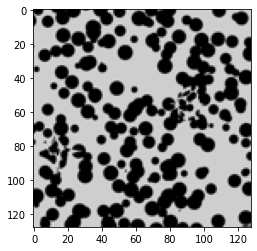

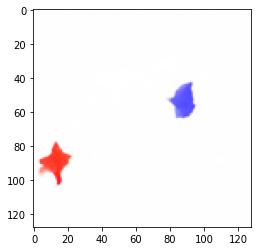

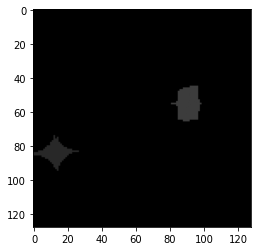

In [182]:
plt.imshow(images[0][0].cpu().numpy().transpose(2, 1, 0))
plt.show()
plt.imshow(flows[0][0].cpu().numpy().transpose(2, 1, 0))
plt.show()
plt.imshow(masks[0][0].cpu().numpy().transpose(2, 1, 0), cmap="gray")
plt.show()

In [183]:
from torch.nn import functional as F
model = SAVi.SlotAttentionVideo(num_slots=3).float().to(device)
out = model(images, cues=masks[:, 0])
torch.autograd.set_detect_anomaly(True)
optim = torch.optim.Adam(model.parameters(), lr=0.0002)

losses = []
for i in range(1000):
    optim.zero_grad()
    out2 = model(images, cues=masks[:, 0])
    recons_combined = out2['recon_combined']

    loss = F.mse_loss(recons_combined, flows)
    loss.backward()
    if i % 10 == 0:
        print(loss.item())
    
    losses.append(loss.item())
    optim.step()
    

0.8322019577026367
0.25533562898635864
0.14570464193820953
0.08816159516572952
0.0536336712539196
0.04107927158474922
0.03474724292755127
0.03042096644639969
0.026745567098259926
0.023192211985588074
0.019776854664087296
0.01667831838130951
0.014010311104357243
0.011834322474896908
0.010136338882148266
0.008895272389054298
0.007984807714819908
0.007382037118077278
0.0070168450474739075
0.006797713227570057
0.006654876284301281
0.006547791883349419
0.006464094389230013
0.0063948798924684525
0.006336033809930086
0.006285912822932005
0.006241558585315943
0.006201081443578005
0.0061636618338525295
0.006130114663392305
0.00609741173684597
0.006065889727324247
0.006035752594470978
0.006005329079926014
0.005978106986731291
0.0059450650587677956
0.005910306703299284
0.005873714108020067
0.005835091229528189
0.005794439930468798
0.005750840064138174
0.005706023424863815
0.005663116928189993
0.005615094676613808
0.005569992586970329
0.005529236048460007
0.005485823843628168
0.00544377975165844
0

In [200]:
out2.keys()

dict_keys(['recon_combined', 'recons', 'masks', 'slots'])

In [184]:
recons = (recons_combined - recons_combined.min()) / recons_combined.max()

In [215]:
masks = out2['masks']
masks_usable = masks.squeeze(0).detach().cpu().numpy().transpose(1, 0, 2, 3, 4)

In [206]:
out2['recons'].shape

torch.Size([1, 10, 3, 128, 128, 3])

In [218]:
list_masks = list(masks_usable)

In [216]:
titles = [f"mask_{i}" for i in range(3)]

In [186]:
import sys
sys.path.append("../")
from utils import make_video


(<Figure size 864x576 with 3 Axes>,
 <matplotlib.animation.FuncAnimation at 0x2b1af394fdf0>)

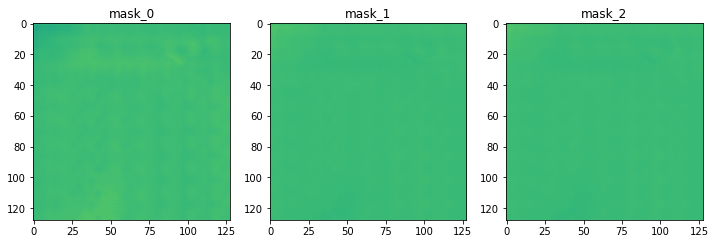

In [227]:
make_video(list_masks, titles=titles, output_name="masks")

In [187]:
recons.shape

torch.Size([1, 10, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


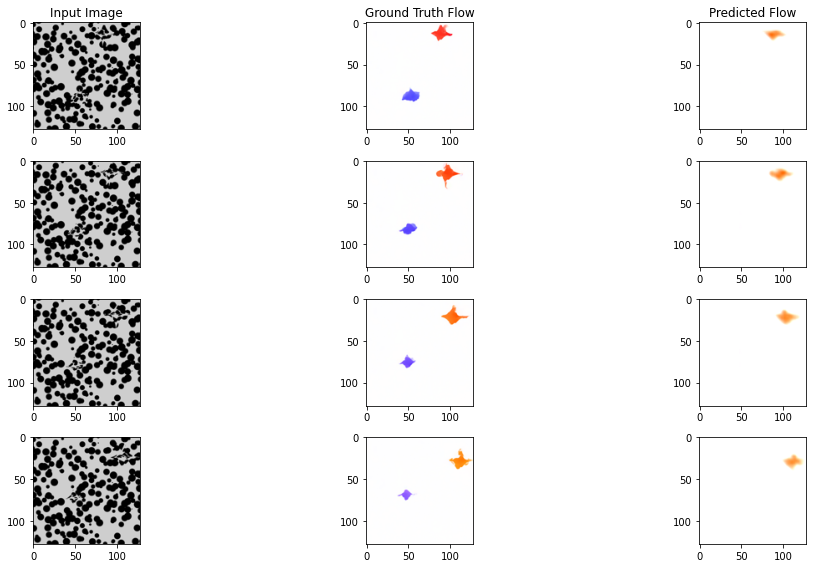

In [207]:
fig, axs = plt.subplots(4, 3, figsize=(16, 8))

for i in range(4):
    img= axs[i, 0].imshow(images[0][i*2].detach().cpu().numpy().transpose(1, 2, 0))
    axs[i, 1].imshow(flows[0][i* 2].detach().cpu().numpy().transpose(1, 2, 0))
    axs[i, 2].imshow(recons[0][i*2].detach().cpu().numpy().transpose(1, 2, 0))

axs[0, 0].set_title("Input Image")
axs[0, 1].set_title("Ground Truth Flow")
axs[0, 2].set_title("Predicted Flow")

plt.tight_layout()
plt.show()

TypeError: Invalid shape (8, 8, 64) for image data

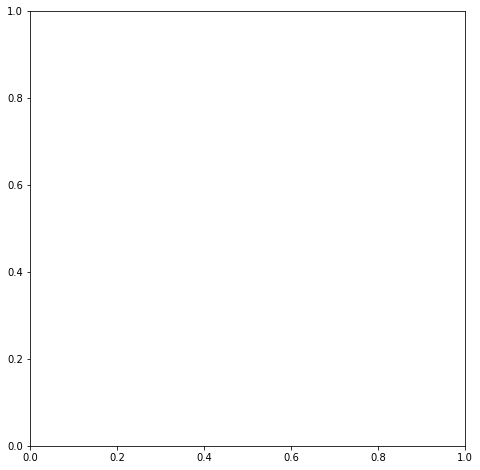

In [204]:
vid = make_video(masks_usable[1], 
                output_dir="figures", output_name="slots_0", format="mp4")

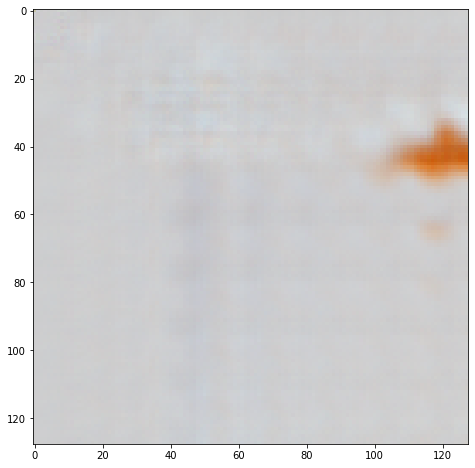

In [17]:
import sys
sys.path.append("../")
from utils import make_video
from matplotlib import animation
from IPython.display import HTML
from matplotlib import animation, rc

fig1, ani1 = make_video(recons.squeeze().detach().cpu().numpy().transpose(0, 2, 3, 1), 
                        output_dir="figures", output_name="overfit_0", format="mp4")
HTML(ani1.to_jshtml())
plt.show()


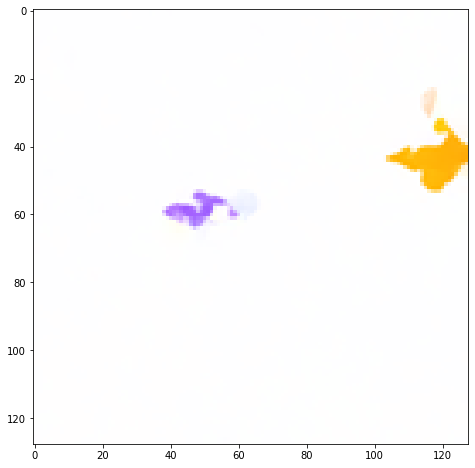

In [18]:
fig2, ani2 = make_video(flows.squeeze().detach().cpu().numpy().transpose(0, 2, 3, 1),
                       output_dir="figures", output_name="overfit_0_flows", format="mp4")
HTML(ani2.to_jshtml())
plt.show()


<IPython.core.display.Javascript object>


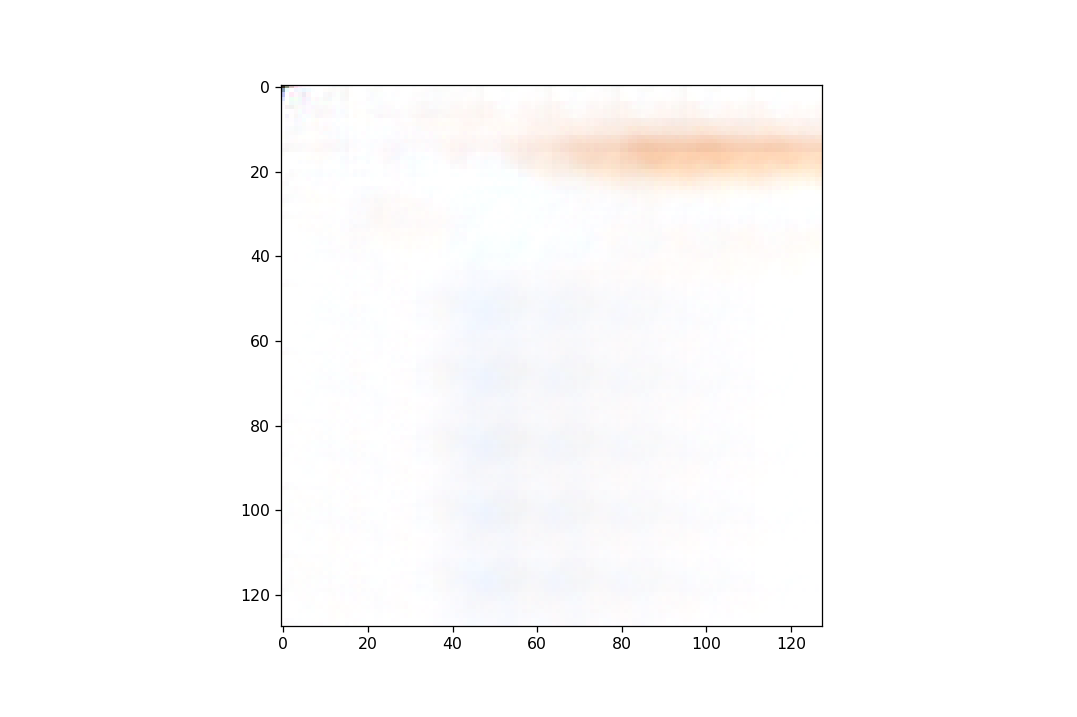

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [477]:
plt.imshow(recons_combined[0, 1].permute(1, 2, 0).detach().cpu().numpy())
plt.show()
